## PlotBot

Build a Twitter bot that sends out visualized sentiment analysis of a Twitter account's recent tweets.

Visit [https://twitter.com/PlotBot5](https://twitter.com/PlotBot5) for an example of what your script should do.

The bot receives tweets via mentions and in turn performs sentiment analysis on the most recent twitter account specified in the mention

For example, when a user tweets, __"@PlotBot Analyze: @CNN,"__ it will trigger a sentiment analysis on the CNN twitter feed.

A plot from the sentiment analysis is then tweeted to the PlotBot5 twitter feed. See below for examples of scatter plots you will generate:

![@juanitasoranno.png](images/@juanitasoranno.png)

Hints, requirements, and considerations:

* Your bot should scan your account every __five minutes__ for mentions.
* Your bot should pull 500 most recent tweets to analyze for each incoming request.
* Your script should prevent abuse by analyzing __only__ Twitter accounts that have not previously been analyzed.
* Your plot should include meaningful legend and labels.
* It should also mention the Twitter account name of the requesting user.
* When submitting your assignment, be sure to have at least __three__ analyses tweeted out from your account (enlist the help of classmates, friends, or family, if necessary!).
* Notable libraries used to complete this application include: Matplotlib, Pandas, Tweepy, TextBlob, and Seaborn.
* You may find it helpful to organize your code in function(s), then call them.
* If you're not yet familiar with creating functions in Python, here is a tutorial you may wish to consult: [https://www.tutorialspoint.com/python/python_functions.htm](https://www.tutorialspoint.com/python/python_functions.htm)
Your final Jupyter notebook must:

* Pull last 100 tweets from each outlet.
* Perform a sentiment analysis with the compound, positive, neutral, and negative scoring for each tweet.
* Pull into a DataFrame the tweet's source acount, its text, its date, and its compound, positive, neutral, and negative sentiment scores.
* Export the data in the DataFrame into a CSV file.
* Save PNG images for each plot.

As final considerations:

* Use the Matplotlib and Seaborn libraries.
* Include a written description of three observable trends based on the data.
* Include proper labeling of your plots, including plot titles (with date of analysis) and axes labels.
* Include an exported markdown version of your Notebook called  `README.md` in your GitHub repository.

In [150]:
# Dependencies
import tweepy
import pandas as pd
from pprint import pprint
from config import *
import os
# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
import matplotlib.pyplot as plt
from datetime import datetime
import ast
from time import sleep

In [2]:
# Twitter API Keys
consumer_key = consumer_key
consumer_secret = consumer_secret
access_token = access_token
access_token_secret = access_token_secret

# Twitter credentials
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

## Helpers

In [3]:
def rwCSV(path,rw='r',df=None,columns=None):
    '''
    Reads CSV from path to pandas dataframe (rw='r')
    Writes/appends to CSV path from pandas dataframe (rw='w')
    Columns: array-like
    '''
    if rw=='r':
        if os.path.isfile(path): 
            print('rwCSV: returning DF from CSV')
            return pd.read_csv(path)
        else: 
            print(f'rwCSV: returning new DF with columns: {columns}')
            return pd.DataFrame(columns=columns)
    elif rw=='w':
        df = pd.DataFrame(df)
        # if file does not exist write with header 
        if not os.path.isfile(path):
            df.to_csv(path,index=False, columns=columns)
            print(f"rwCSV: saved {df.shape[0]} row(s) as new file to '{path}'")
        else: # else it exists so append without writing the header
            df.to_csv(path,mode = 'a',header=False,index=False, columns=columns)
            print(f"rwCSV: appended {df.shape[0]} row(s) to '{path}'")

In [111]:
def getMentions():
    '''
    gets mentions from twitter and saves to CSV file
    '''
    #set up resulting columns
    columns = ['mention_tweet_id','text','mentioned_users','mention_date', \
               'mention_user_id','mention_user_name','full_response']

    #set up my twitter account number
    my_id = api.me()['id']

    #get mentions
    try:
        mention_response = api.mentions_timeline()
        #print('got some kind of response')
    except tweepy.TweepError as e:
        print(f"getMentions: Something's not right. Error: {e}")
        mention_response = False

    #if there are mentions go on
    if mention_response:
        print(f'getMentions: Got response with {len(mention_response)} tweet(s)')

        # try reading mentions CSV
        path = 'results/mentions.csv'
        mentions_df = rwCSV(path,columns=columns)
        new_mentions_df = pd.DataFrame(columns=columns)

        #add mentions to a DF
        for response in mention_response:
            #set up mentioned list
            mentioned_list = []

            #create list of mentioned users
            for mention in response['entities']['user_mentions']:
                if mention['id'] != my_id:
                    print(f"getMentions: adding mention id: {mention['id']}")
                    mentioned_list.append(mention['id'])

            #check if the tweet has already been added to DF
            #and that there are in fact mentioned users in the tweet
            if response['id'] not in mentions_df['mention_tweet_id'].tolist() and \
                len(mentioned_list) > 0:
                mentions_dict = {'mention_tweet_id':response['id'],
                                 'text':response['text'],
                                 'mentioned_users':mentioned_list,
                                 'mention_date':response['created_at'],
                                 'mention_user_id':response['user']['id'],
                                 'mention_user_name':response['user']['name'],
                                 'full_response':response \
                                }
                #grab all the mentions (append to CSV)
                mentions_df = mentions_df.append(mentions_dict,ignore_index=True)
                
                #grab only new mentions (append to empty DF)
                new_mentions_df = new_mentions_df.append(mentions_dict,ignore_index=True)
                #convert dates
                mentions_df['mention_date'] = pd.to_datetime(mentions_df['mention_date'])
                new_mentions_df['mention_date'] = pd.to_datetime(mentions_df['mention_date'])
            else:
                print(f"getMentions: Tweet id: {response['id']} is in CSV already or doesn't have a valid mentioned user")
        #save to CSV
        if new_mentions_df.shape[0] > 0:
            print(f'getMentions: saving new mentions to CSV')
            rwCSV(path,'w',new_mentions_df,columns)
        else:
            print('getMentions: No new mentions')

    #if getMentions() responded with False
    else: 
        print('getMentions: No new mentions')
    return mentions_df

In [175]:
def getSentiment(id,pages=1):
    '''
    Returns 'pages'*100 compound sentiment analysis for twitter user 'id'
    '''
    mentioned_user = id
    
    if pages > 5: pages = 5
    else: pages = pages
        
    count = 100

    sentiment_df = pd.DataFrame()
    
    #setup list for tweets
    tweets_of_mentioned_user = []

    #get and analyse tweets
    for page in range(1,pages+1):

        #get 100 tweets at once
        print(f'getSentiment: trying to obtain tweets for user id {mentioned_user}, page {page}')
        try:
            public_tweets = api.user_timeline(id=mentioned_user,count=count,page=page)
        except:
            public_tweets = False

        #loop through obtained tweets
        if public_tweets:
            for tweet in public_tweets:
                result = analyzer.polarity_scores(tweet["text"])

                sentiment_dict = {
                    'user_id':mentioned_user,
                    'date':tweet['created_at'],
                    'tweet':tweet["text"],
                    'compound':result['compound'],
                    'positive':result['pos'],
                    'neutral':result['neu'],
                    'negative':result['neg']
                }

                #grab all the mentions
                sentiment_df = sentiment_df.append(sentiment_dict,ignore_index=True)

    return sentiment_df

In [196]:
def makeGraph(df,mentioned_user):
    path = 'results/image.png'
    mentioned_user_name = api.get_user(mentioned_user)['screen_name']
    plt.style.use('fivethirtyeight')
    f, ax = plt.subplots(figsize=(20,10))
    df.plot(marker="o",markersize=10,linewidth=0.5, alpha=0.8)
    plt.gca().invert_xaxis()
    plt.xlim([len(df.index),0])
    plt.ylabel("Tweet polarity \n<negative.........positive>")
    plt.xlabel("Tweets Ago")
    now = datetime.now()
    now = now.strftime("%m/%d/%Y")
    plt.title(f"Sentiment analysis of @{mentioned_user_name} tweets as of {now}")
    plt.savefig(path, format='png')
    plt.show()
    plt.close()
    #api.update_with_media(path)
    return mentioned_user_name

## Worker

In [206]:
def worker():
    #get new mentions as DF
    mentions_df = getMentions()

    #setup resulting CSV
    path_to_analyzed = 'results/analyzed.csv'
    path_to_sentiment = 'results/sentiment.csv'
    columns_analyzed = ['user_id','user_name']
    columns_sentiment = ['compound', 'tweet']
    print('worker: trying to read analyzed CSV')
    analyzed_df = rwCSV(path,columns=columns_analyzed)

    #got through not analyzed rows
    for index, row in mentions_df.iterrows():
        #get the list of mentioned users
        #Note. for some reason `row` returns a string type variable and not list
        #therefore using ast.literal_eval function to convert it to list
        
        if row['mentioned_users']:
            mentioned_users = ast.literal_eval(str(row['mentioned_users']))
            #loop through the list to analyse tweets and post graphs
            for mentioned_user in mentioned_users:
                if mentioned_user not in analyzed_df['user_id'].tolist():
                    print(f'worker: performing sentiment analysis for user_id {mentioned_user}')
                    sentiment = getSentiment(mentioned_user,pages=5)
                    rwCSV(path_to_sentiment,'w',df=sentiment,columns = columns_sentiment)

                    print(f'worker: performed sentiment analysis for user_id {mentioned_user}')
                    mentioned_user_name = makeGraph(sentiment['compound'],mentioned_user)
                    print(f'worker: generated and tweeted graph for @{mentioned_user_name}')

                    #change flag to analyzed and save CSV
                    analyzed_df = analyzed_df.append({'user_name':mentioned_user_name,
                                                      'user_id':mentioned_user
                                                      },ignore_index=True)
                    rwCSV(path_to_analyzed,'w',analyzed_df,columns)
                else:
                    print(f'worker: user id: {mentioned_user} has already been analyzed')
            

Initializing worker:
getMentions: Got response with 4 tweet(s)
rwCSV: returning DF from CSV
getMentions: adding mention id: 80067314
getMentions: Tweet id: 985700911614918658 is in CSV already or doesn't have a valid mentioned user
getMentions: adding mention id: 17842366
getMentions: Tweet id: 983829906302873601 is in CSV already or doesn't have a valid mentioned user
getMentions: adding mention id: 979490736013021184
getMentions: Tweet id: 983757509960839168 is in CSV already or doesn't have a valid mentioned user
getMentions: Tweet id: 983698615347613696 is in CSV already or doesn't have a valid mentioned user
getMentions: No new mentions
worker: trying to read analyzed CSV
rwCSV: returning new DF with columns: ['user_id', 'user_name']
worker: performing sentiment analysis for user_id 17842366
getSentiment: trying to obtain tweets for user id 17842366, page 1
getSentiment: trying to obtain tweets for user id 17842366, page 2
getSentiment: trying to obtain tweets for user id 17842366

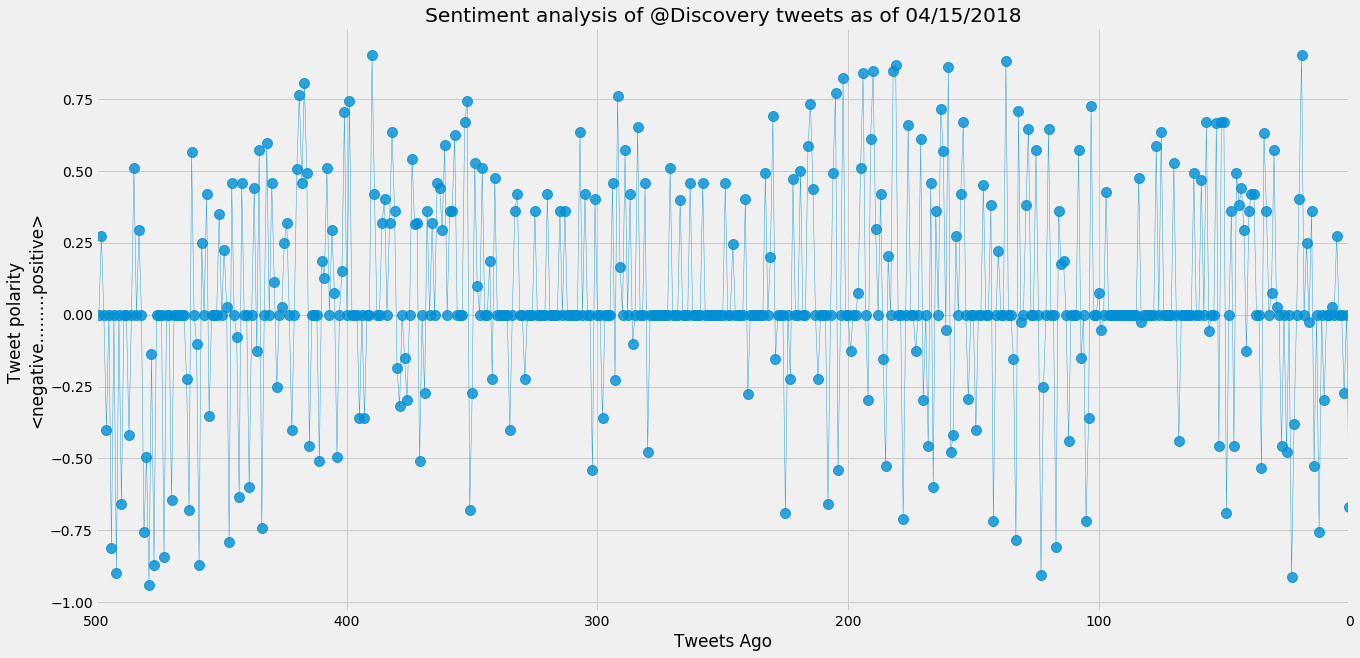

worker: generated and tweeted graph for @Discovery
rwCSV: saved 1 row(s) as new file to 'results/analyzed.csv'
worker: performing sentiment analysis for user_id 979490736013021184
getSentiment: trying to obtain tweets for user id 979490736013021184, page 1
getSentiment: trying to obtain tweets for user id 979490736013021184, page 2
getSentiment: trying to obtain tweets for user id 979490736013021184, page 3
getSentiment: trying to obtain tweets for user id 979490736013021184, page 4
getSentiment: trying to obtain tweets for user id 979490736013021184, page 5
rwCSV: appended 336 row(s) to 'results/sentiment.csv'
worker: performed sentiment analysis for user_id 979490736013021184


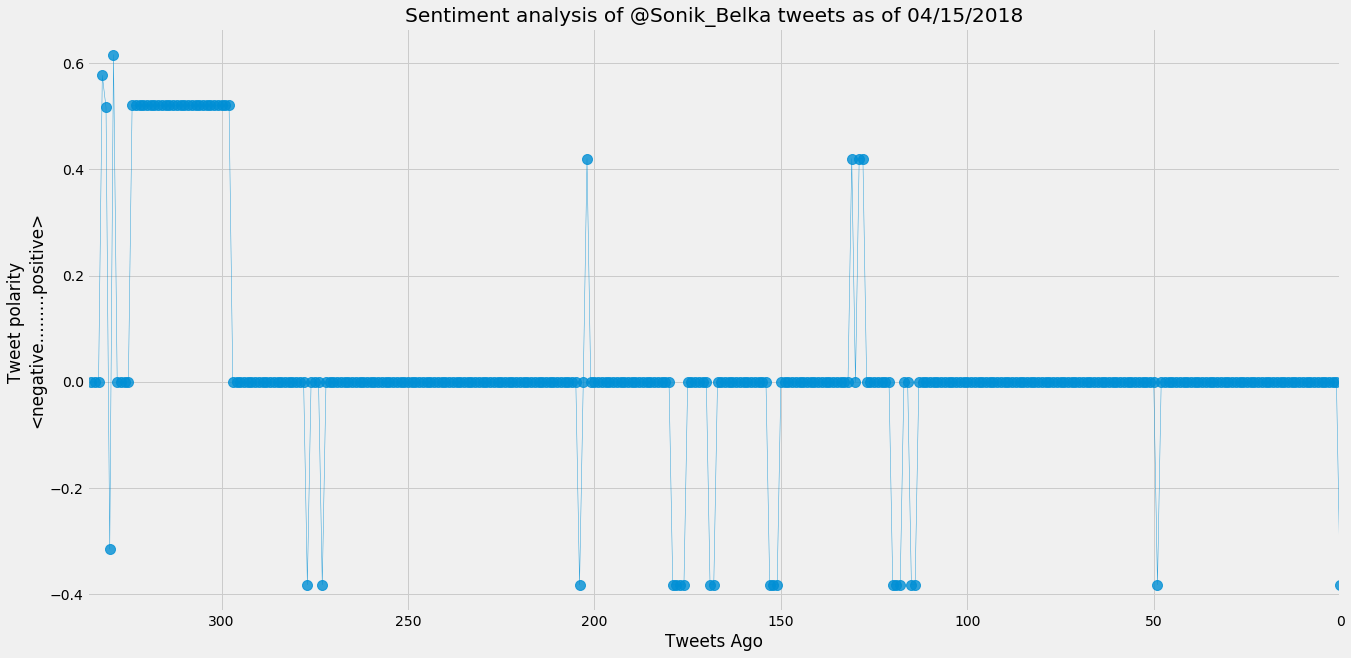

worker: generated and tweeted graph for @Sonik_Belka
rwCSV: appended 2 row(s) to 'results/analyzed.csv'
worker: performing sentiment analysis for user_id 80067314
getSentiment: trying to obtain tweets for user id 80067314, page 1
getSentiment: trying to obtain tweets for user id 80067314, page 2
getSentiment: trying to obtain tweets for user id 80067314, page 3
getSentiment: trying to obtain tweets for user id 80067314, page 4
getSentiment: trying to obtain tweets for user id 80067314, page 5
rwCSV: appended 500 row(s) to 'results/sentiment.csv'
worker: performed sentiment analysis for user_id 80067314


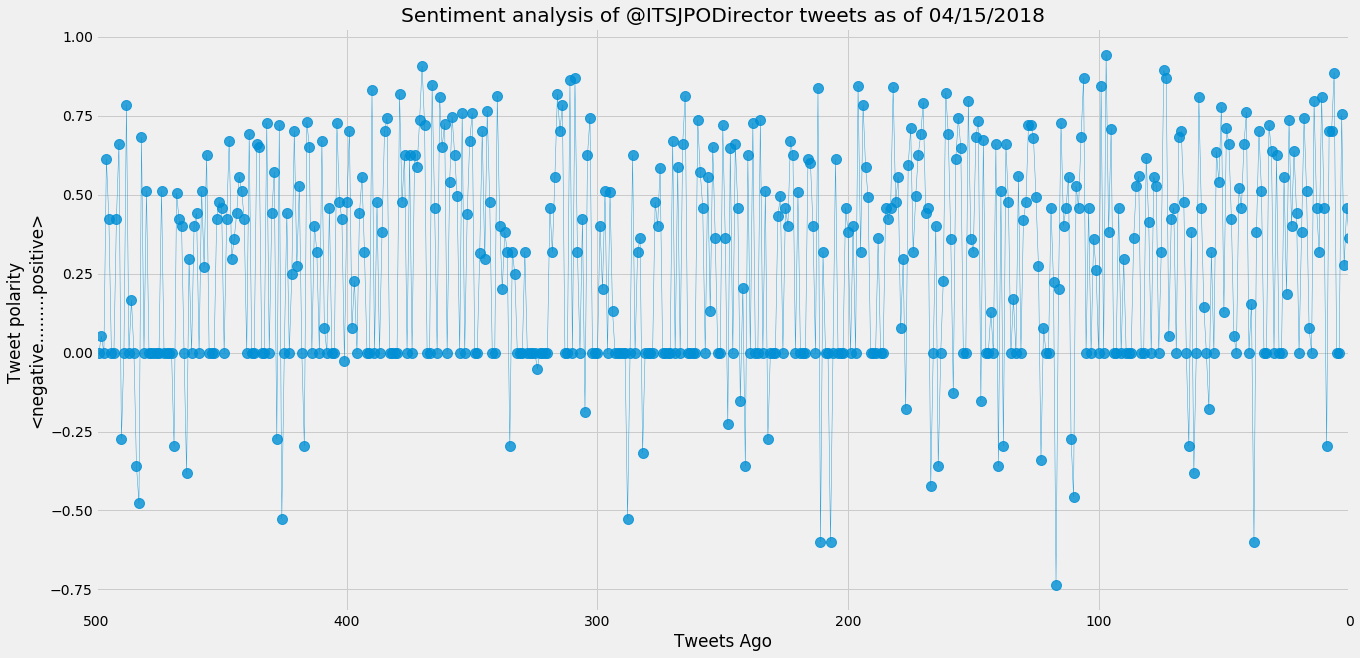

worker: generated and tweeted graph for @ITSJPODirector
rwCSV: appended 3 row(s) to 'results/analyzed.csv'


KeyboardInterrupt: 

In [208]:
# run the program
if __name__ == '__main__':
    while True:
        print('Initializing worker:')
        worker()
        sleep(300)

## Trends
1. Bot of a fellow student appeares to be tweeting neutral texts
2. @Discovery tends to be more positive
3. @ITSJPODirector is vastly positive on twitter